# Analysis of reordering of NIL for reprogramming

## Load data
Notes:

1. Only singlets are included

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib.ticker import ScalarFormatter
from pathlib import Path
import re
import seaborn as sns
import scipy
from statannotations.Annotator import Annotator
import rushd as rd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Required descriptors for annotate
from statannotations.stats.StatTest import StatTest
from scipy.stats import ttest_ind
custom_long_name = 't-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_greater'
custom_func = ttest_ind
ttest_ind_greater = StatTest(custom_func, custom_long_name, custom_short_name, alternative='greater')

custom_long_name = 't-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_less'
custom_func = ttest_ind
ttest_ind_less = StatTest(custom_func, custom_long_name, custom_short_name, alternative='less')

# Look at 4 dpi data

## Load data

Load BAL data

In [2]:
# Directories
datadir_1 = rd.datadir/'2023.07.03_NIL_reorder_staining'
figpath = '../figures/fig2/'

# Load as df and note header is on 0th row
data_4dpi_1 = rd.flow.load_csv_with_metadata(
    datadir_1/'export_singlets', datadir_1/'well_metadata.yaml')

ctrl_data_4dpi_1 = list()
files = Path(datadir_1 / 'export_singlets').glob('*.csv') 
for i, file in enumerate(files):

    # Extract metadata from csv title
    if re.search('Only', file.name) is not None:
        if re.search('Secondary', file.name) is not None:
            regex = 'export_(?P<stain>.+)_Secondary_Only_Singlets.csv'
            isSecondOnly = True
        else:
            regex = 'export_(?P<stain>.+)_Only_Singlets.csv'
            isSecondOnly = False    
    elif re.search('No_Color', file.name) is not None:
        regex = 'export_(?P<stain>.+)_Singlets.csv'
        isSecondOnly = False
    else:
        continue
    match = re.search(regex , file.name)

    # If no match, keep going
    if match is None:
        print('No match for {}'.format(file.name))
        continue

    # Load as df and note header is on 0th row
    df = pd.read_csv(file, header=0)

    # Update columns in df with metadata from file name
    df['stain'] = match.group('stain')
    df['isSecondOnly'] = isSecondOnly
    df['stainrep'] = 0

    ctrl_data_4dpi_1.append(df)

ctrl_data_4dpi_1 = pd.concat(ctrl_data_4dpi_1, ignore_index=True)

# Remove negative data
data_4dpi_1 = data_4dpi_1.loc[
    (data_4dpi_1['Alexa Fluor™ 647-A'] > 0) &
    (data_4dpi_1['CellTrace™ Violet-A'] > 0)
]
ctrl_data_4dpi_1 = ctrl_data_4dpi_1.loc[
    (ctrl_data_4dpi_1['Alexa Fluor™ 647-A'] > 0) &
    (ctrl_data_4dpi_1['CellTrace™ Violet-A'] > 0)
]

Load NBW data

In [3]:
# Directories
datadir_2 = rd.datadir/'2022.11.09_Hb9_NILx3HA_reorder_stain_4dpi_1-3'/'export_singlets'

# Store all data in list of dfs which will be converted to df at end
data_4dpi_2 = list()
ctrl_data_4dpi_2 = list()

# get all csvs for each dir
files = Path(datadir_2).glob('*.csv') 
for i, file in enumerate(files):

    # Extract metadata from csv title
    # Check if ctrl
    if re.search('Ctrl', file.name) is not None:
        regex = 'export_(?P<stain>.+)_(?P<replicate>\d)_(?P<cond>.+)_Singlets.csv'
        isCtrl = True
    else:
        regex = 'export_(?P<cond>.+)_(?P<replicate>\d)_(?P<stain>.+)_Singlets.csv'
        isCtrl = False
    match = re.search(regex , file.name)

    # If no match, keep going
    if match is None:
        print('No match for {}'.format(file.name))
        continue

    # Load as df and note header is on 0th row
    df = pd.read_csv(file, header=0)

    # Rename DDRR conditions
    cond = match.group('cond')
    DDRR_cat = False
    if cond[-4:] == 'DDRR':
        DDRR_cat = True
        cond = cond[:-5] # cut out .DDRR

    # If ctrl-puro, actually add it to main
    if match.group('stain') == 'Ctrl-puro':
        isCtrl = False
        cond = "Ctrl-puro"
        stain = "None"

    # Update columns in df with metadata from file name
    df['cond'] = cond
    df['DDRR_cat'] = DDRR_cat
    df['cond.DDRR'] = match.group('cond')
    df['replicate'] = int(match.group('replicate'))-1 # To match iMN 0-based indexing
    df['stainrep'] = 1
    
    # Rename Ngn2x3HA
    if match.group('stain') == 'Ngn2x3HA':
        df['stain'] = 'HA (Ngn2$^{x3HA}$)'
    else:
        df['stain'] = match.group('stain')

    if isCtrl:
        ctrl_data_4dpi_2.append(df)
    else:
        data_4dpi_2.append(df)

# Convert list of dfs into single df
data_4dpi_2 = pd.concat(data_4dpi_2, ignore_index=True)
ctrl_data_4dpi_2 = pd.concat(ctrl_data_4dpi_2, ignore_index=True)

# Remove negative data
data_4dpi_2 = data_4dpi_2.loc[
    (data_4dpi_2['Alexa Fluor™ 647-A'] > 0) &
    (data_4dpi_2['eGFP-A'] > 0) &
    (data_4dpi_2['CellTrace™ Violet-A'] > 0)
]
ctrl_data_4dpi_2 = ctrl_data_4dpi_2.loc[
    (ctrl_data_4dpi_2['Alexa Fluor™ 647-A'] > 0) &
    (ctrl_data_4dpi_2['eGFP-A'] > 0) &
    (ctrl_data_4dpi_2['CellTrace™ Violet-A'] > 0)
]

In [4]:
# Combine both sets of data
data_4dpi = pd.concat([data_4dpi_1, data_4dpi_2], ignore_index=True)
ctrl_data_4dpi = pd.concat([ctrl_data_4dpi_1, ctrl_data_4dpi_2], ignore_index=True)

## Categorize cells
### Categorize cells based on CellTrace-Violet

In [5]:
# Get CTV-low threshold for each rep s.t.
# CTV_low_thresh = 20% dimmest in ctrl
rep_list = data_4dpi.replicate.unique()
rep_list.sort()
CTV_low_thresh_list = np.zeros(np.shape(rep_list))
for (i, rep) in enumerate(rep_list):
    CTV_low_thresh_list[i] = np.percentile(
        data_4dpi.loc[(data_4dpi['cond'] == 'Ctrl-puro') &
            (data_4dpi['replicate'] == rep)
        ]['CellTrace™ Violet-A'], 20)


# Categorize based on CTV for each rep
data_4dpi['CTV_cat'] = 'CTV-low'
for (i, rep) in enumerate(rep_list):
    data_4dpi.loc[
        (data_4dpi['replicate'] == rep_list[i]) &
        (data_4dpi['CellTrace™ Violet-A'] > CTV_low_thresh_list[i]),
        'CTV_cat'] = 'non-CTV-low'

# Calculate BV 421 populations using these metrics
well_group = ['cond', 'DDRR_cat', 'replicate',]
count_df = data_4dpi.groupby([*well_group, 'CTV_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if none rather than dropping row
CTV_percent_4dpi = (count_df*100/count_df.groupby([*well_group]
                           ).transform('sum')).reset_index(name='percent')

# Extract just the hyperP
CTV_hyperP_percent_4dpi = CTV_percent_4dpi.loc[(CTV_percent_4dpi['CTV_cat'] == 'CTV-low')]

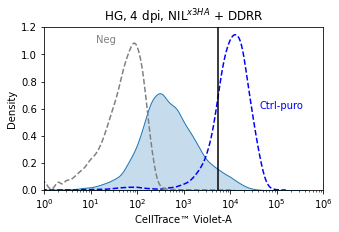

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Threshold for iMNs
rep = 2
CTV_low_thresh = CTV_low_thresh_list[rep-1]

# Plot eGFP-A
x = 'CellTrace™ Violet-A'
sns.kdeplot(data=data_4dpi.loc[
    (data_4dpi['cond.DDRR'] == 'NILx3HA.DDRR') & (data_4dpi['replicate'] == rep)],
    ax=ax, x=x,
    common_norm=False, log_scale=(True, False),
    fill=True)

# Plot CTV control
sns.kdeplot(data=data_4dpi[(data_4dpi['cond'] == 'Ctrl-puro') & (data_4dpi['replicate'] == rep)], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='blue', fill=False, linestyle='--')
ax.annotate('Ctrl-puro', (0.85, 0.5), color='blue' , xycoords='axes fraction', ha='center')

# Plot neg ctrl
sns.kdeplot(data=ctrl_data_4dpi[(ctrl_data_4dpi['stain'] == 'No_Color')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.22, 0.9), color='grey', xycoords='axes fraction', ha='center')

# Plot threshold
ax.axvline(CTV_low_thresh, 0, 1, color='black')

# Title
plt.title('HG, 4 dpi, NIL$^{x3HA}$ + DDRR')
# Adjust limits
CTV_lim = (1, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(CTV_lim)

## Look at HyperP at 4 dpi

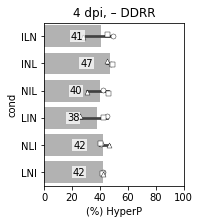

In [7]:
# General plotting params
y = 'cond'
x = 'percent'
cond_list = ['ILNx3HA', 'INLx3HA', 'NILx3HA', 'LINx3HA', 'NLIx3HA', 'LNIx3HA']
marker_list = ['o', 's', '^', 'D', 'P', 'X']

fig, ax = plt.subplots(1, 1, figsize=(2.5, 3))

# Plot hyperP of all cells for -DDRR
color='black'
sns.barplot(ax=ax, data=CTV_hyperP_percent_4dpi.loc[(CTV_hyperP_percent_4dpi['DDRR_cat'] == False)],
            x=x, y=y, order=cond_list,
            color=color, alpha=0.3, orient='h')

for (i, rep) in enumerate(rep_list):
    sns.stripplot(
        ax=ax,
        data=CTV_hyperP_percent_4dpi.loc[(CTV_hyperP_percent_4dpi['DDRR_cat'] == False) & (CTV_hyperP_percent_4dpi.replicate == rep)],
        x=x, y=y, order=cond_list,
        marker=marker_list[i],
        color='white', size=5, orient='h', dodge=True,
        edgecolor='black', linewidth=0.4
        )

# Add barplot labels
for sub_ax in plt.gcf().get_axes():
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.0f', padding=-30)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))    
    sub_ax.xaxis.set_label_text('(%) HyperP')

# Format
ax.set_title('4 dpi, \u2013 DDRR')
ax.set_xticks(np.arange(0, 110, 20))
ax.set_yticklabels(
    ['ILN', 'INL', 'NIL', 'LIN', 'NLI', 'LNI'])

plt.savefig(figpath + 'SI/4dpi_hyperP_hor-noDDRR.svg', bbox_inches='tight')

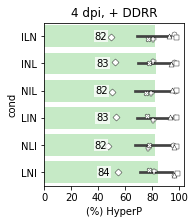

In [8]:
# General plotting params
y = 'cond'
x = 'percent'
cond_list = ['ILNx3HA', 'INLx3HA', 'NILx3HA', 'LINx3HA', 'NLIx3HA', 'LNIx3HA']
marker_list = ['o', 's', '^', 'D', 'P', 'X']

fig, ax = plt.subplots(1, 1, figsize=(2.5, 3))

# Plot hyperP percent of all cells for +DDRR
color='limegreen'
sns.barplot(ax=ax, data=CTV_hyperP_percent_4dpi.loc[(CTV_hyperP_percent_4dpi['DDRR_cat'] == True)],
            x=x, y=y, order=cond_list,
            color=color, alpha=0.3, orient='h')
for (i, rep) in enumerate(rep_list):
    sns.stripplot(
        ax=ax,
        data=CTV_hyperP_percent_4dpi.loc[(CTV_hyperP_percent_4dpi['DDRR_cat'] == True) & (CTV_hyperP_percent_4dpi.replicate == rep)],
        x=x, y=y, order=cond_list,
        marker=marker_list[i],
        color='white', size=5, orient='h', dodge=True,
        edgecolor='black', linewidth=0.4
        )

# Add barplot labels
for sub_ax in plt.gcf().get_axes():
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.0f', padding=-60)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))    
    sub_ax.xaxis.set_label_text('(%) HyperP')

# Format
ax.set_title('4 dpi, + DDRR')
ax.set_xticks(np.arange(0, 110, 20))
ax.set_yticklabels(
    ['ILN', 'INL', 'NIL', 'LIN', 'NLI', 'LNI'])

plt.savefig(figpath + 'SI/4dpi_hyperP_hor-DDRR.svg', bbox_inches='tight')

It looks like hyperP doesn't really vary, check with ANOVA

In [9]:
# perform two-way ANOVA for - DDRR
# Ignore Ctrl-puro because that's whatdefines hyperP
model = ols('percent ~ C(cond)', data=CTV_hyperP_percent_4dpi.loc[(CTV_hyperP_percent_4dpi.DDRR_cat == False) & (CTV_hyperP_percent_4dpi.cond != 'Ctrl-puro')]).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(cond),155.770097,5.0,0.603148,0.699101
Residual,619.828671,12.0,NaN,NaN


In [10]:
# perform two-way ANOVA for + DDRR
# Ignore Ctrl-puro because that's whatdefines hyperP
model = ols('percent ~ C(cond)', data=CTV_hyperP_percent_4dpi.loc[(CTV_hyperP_percent_4dpi.DDRR_cat == True) & (CTV_hyperP_percent_4dpi.cond != 'Ctrl-puro')]).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(cond),19.527798,5.0,0.012358,0.999945
Residual,9481.419764,30.0,NaN,NaN


Look at DDRR conditions in more detail

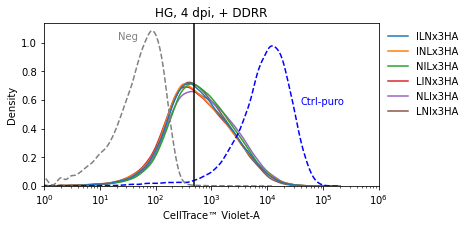

In [11]:
# Plotting params
x = 'CellTrace™ Violet-A'
hue = 'cond'
cond_list = ['ILNx3HA', 'INLx3HA', 'NILx3HA', 'LINx3HA', 'NLIx3HA', 'LNIx3HA']

# Threshold for iMNs
rep = 4
CTV_low_thresh = CTV_low_thresh_list[rep-1]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

sns.kdeplot(data=data_4dpi.loc[(data_4dpi['replicate'] == rep)],
    ax=ax, x=x, hue=hue, hue_order=cond_list,
    common_norm=False, log_scale=(True, False),
    fill=False)

# Plot CTV control
sns.kdeplot(data=data_4dpi[(data_4dpi['cond'] == 'Ctrl-puro')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='blue', fill=False, linestyle='--')
ax.annotate('Ctrl-puro', (0.83, 0.5), color='blue' , xycoords='axes fraction', ha='center')

# Plot neg ctrl
sns.kdeplot(data=ctrl_data_4dpi[(ctrl_data_4dpi['stain'] == 'No_Color')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.25, 0.9), color='grey', xycoords='axes fraction', ha='center')

# Plot threshold
ax.axvline(CTV_low_thresh, 0, 1, color='black')

# Title
plt.title('HG, 4 dpi, + DDRR')
# Adjust limits
CTV_lim = (1, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(CTV_lim)
# Move legend
sns.move_legend(ax, title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

## Look at protein level data

### Look at single color controls first

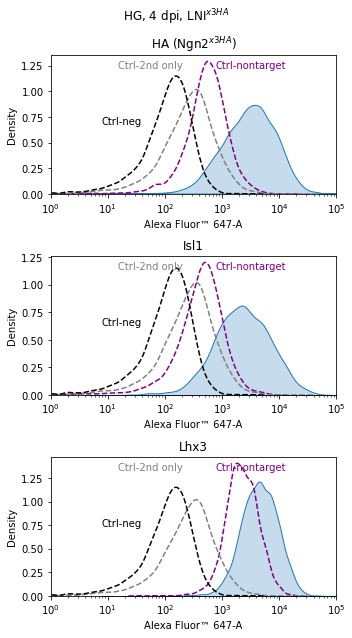

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(5, 9))

# Plottting parameters
x = 'Alexa Fluor™ 647-A'
stain_list = ['HA (Ngn2$^{x3HA}$)', 'Isl1', 'Lhx3']
rep = 1
cond = 'LNIx3HA'

for (i, stain) in enumerate(stain_list):

    # Plot actual stain
    ax[i].title.set_text(stain) 
    sns.kdeplot(data=data_4dpi.loc[
        (data_4dpi['cond.DDRR'] == cond) & (data_4dpi['stain'] == stain) & (data_4dpi['replicate'] == rep)],
        ax=ax[i], x=x,
        common_norm=False, log_scale=(True, False),
        fill=True)

    # Plot non-targetting control
    # Rename Ngn2 because of diff nomenclature between NBW/BAL
    if stain == 'HA (Ngn2$^{x3HA}$)':
        stain_name = "Ctrl-Ngn2x3HA"
    else:
        stain_name = 'Ctrl-{}'.format(stain)
    sns.kdeplot(data=ctrl_data_4dpi[(ctrl_data_4dpi['stain'] == stain_name)], x=x, common_norm=False,
                ax=ax[i], log_scale=(True, False), color='purple', fill=False, linestyle='--')
    ax[i].annotate('Ctrl-nontarget', (0.7, 0.9), color='purple' , xycoords='axes fraction', ha='center')

     # Plot 2nd ctrl
    sns.kdeplot(data=ctrl_data_4dpi[(ctrl_data_4dpi['stain'] == 'Ctrl-2nd')], x=x, common_norm=False,
                ax=ax[i], log_scale=(True, False), color='grey', fill=False, linestyle='--')
    ax[i].annotate('Ctrl-2nd only', (0.35, 0.9), color='grey' , xycoords='axes fraction', ha='center')

    # Plot neg ctrl
    sns.kdeplot(data=ctrl_data_4dpi[(ctrl_data_4dpi['stain'] == 'Ctrl-neg')], x=x, common_norm=False,
                ax=ax[i], log_scale=(True, False), color='black', fill=False, linestyle='--')
    ax[i].annotate('Ctrl-neg', (0.25, 0.5), color='black', xycoords='axes fraction', ha='center')

# Title
plt.suptitle('HG, 4 dpi, LNI$^{x3HA}$')
# Adjust limits
AF_lim = (1, 1*10**5)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(AF_lim)

# Misc plotting stuff
fig.tight_layout()  # Helps improve white spacing
plt.savefig(figpath + 'SI/4dpi_single_color_ctrl_dist-{}.svg'.format(cond), bbox_inches='tight')

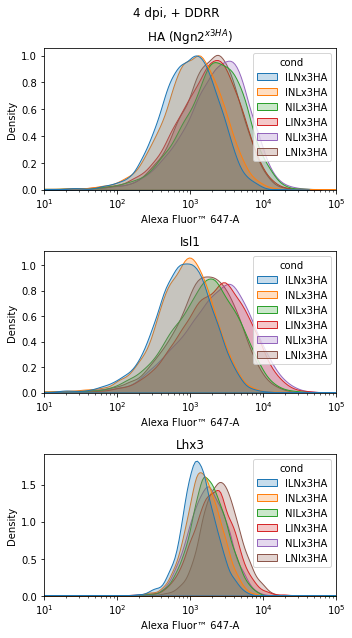

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(5, 9))

# Plottting parameters
x = 'Alexa Fluor™ 647-A'
stain_list = ['HA (Ngn2$^{x3HA}$)', 'Isl1', 'Lhx3']
rep = 1
hue = 'cond'
hue_order = ['ILNx3HA', 'INLx3HA', 'NILx3HA', 'LINx3HA', 'NLIx3HA', 'LNIx3HA']

for (i, stain) in enumerate(stain_list):

    # Plot actual stain
    ax[i].title.set_text(stain) 
    sns.kdeplot(data=data_4dpi.loc[
        (data_4dpi['DDRR_cat'] == True) & (data_4dpi['stain'] == stain) & (data_4dpi['replicate'] == rep) & (data_4dpi['CTV_cat'] == 'CTV-low')],
        ax=ax[i], x=x, hue=hue, hue_order=hue_order,
        common_norm=False, log_scale=(True, False),
        fill=True)

# Title
plt.suptitle('4 dpi, + DDRR')
# Adjust limits
AF_lim = (10**1, 1*10**5)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(AF_lim)

# Misc plotting stuff
fig.tight_layout()  # Helps improve white spacing

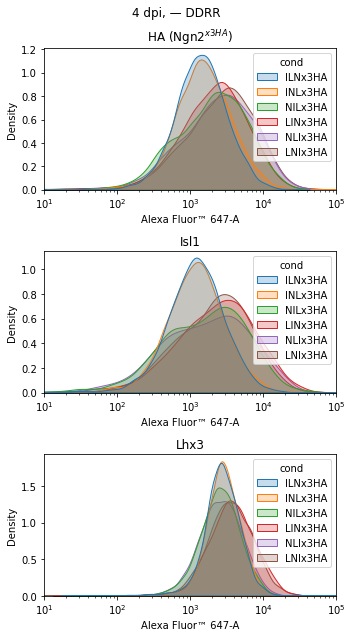

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(5, 9))

# Plottting parameters
x = 'Alexa Fluor™ 647-A'
stain_list = ['HA (Ngn2$^{x3HA}$)', 'Isl1', 'Lhx3']
rep = 1
hue = 'cond'
hue_order = ['ILNx3HA', 'INLx3HA', 'NILx3HA', 'LINx3HA', 'NLIx3HA', 'LNIx3HA']

for (i, stain) in enumerate(stain_list):

    # Plot actual stain
    ax[i].title.set_text(stain) 
    sns.kdeplot(data=data_4dpi.loc[
        (data_4dpi['DDRR_cat'] == False) & (data_4dpi['stain'] == stain) & (data_4dpi['replicate'] == rep) & (data_4dpi['CTV_cat'] == 'CTV-low')],
        ax=ax[i], x=x, hue=hue, hue_order=hue_order,
        common_norm=False, log_scale=(True, False),
        fill=True)

# Title
plt.suptitle('4 dpi, — DDRR')
# Adjust limits
AF_lim = (10**1, 1*10**5)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(AF_lim)

# Misc plotting stuff
fig.tight_layout()  # Helps improve white spacing

### Look at mean levels

#### Normalize staining

In [15]:
x = 'Alexa Fluor™ 647-A'
stain_list = ['HA (Ngn2$^{x3HA}$)', 'Isl1', 'Lhx3']

# Calculate mean of each sample
well_group = ['stainrep', 'stain', 'cond', 'DDRR_cat', 'replicate', 'CTV_cat']
data_4dpi_stain_mean = data_4dpi.groupby(
        well_group)[x].apply(scipy.stats.gmean).reset_index(name=x+' (gmean)')

# For violin plots, first log10 transform data
data_4dpi['log({})'.format(x)] = np.log10(data_4dpi[x])
data_4dpi_stain_mean['log({})'.format(x+' (gmean)')] = np.log10(data_4dpi_stain_mean[x+' (gmean)'])

# Normalize to ILN + DDRR in log10 space for each rep
rep_list = data_4dpi_stain_mean['replicate'].unique()
base = np.zeros((len(rep_list), len(stain_list)))

for (i, replicate) in enumerate(rep_list):
    for (j, stain) in enumerate(stain_list):
        base[i, j] = data_4dpi_stain_mean.loc[
            (data_4dpi_stain_mean.stain == stain) & 
            (data_4dpi_stain_mean.cond == 'ILNx3HA') &
            (data_4dpi_stain_mean.DDRR_cat == True) &
            (data_4dpi_stain_mean.replicate == replicate) &
            (data_4dpi_stain_mean.CTV_cat == 'CTV-low')]['log({})'.format(x+' (gmean)')].mean()

        data_4dpi.loc[(data_4dpi.replicate==replicate) & (data_4dpi.stain==stain), 'Norm log({})'.format(x)] = \
            data_4dpi[(data_4dpi.replicate==replicate) & (data_4dpi.stain==stain)]['log({})'.format(x)] - base[i,j] + 1

        data_4dpi_stain_mean.loc[(data_4dpi_stain_mean.replicate==replicate) & (data_4dpi_stain_mean.stain==stain), 'Norm log({})'.format(x+' (gmean)')] = \
            data_4dpi_stain_mean[(data_4dpi_stain_mean.replicate==replicate) & (data_4dpi_stain_mean.stain==stain)]['log({})'.format(x+' (gmean)')] - base[i,j] + 1

# Isolate just hyperP
data_4dpi_stain_mean_hyperP = data_4dpi_stain_mean.loc[data_4dpi_stain_mean.CTV_cat == 'CTV-low']    

### Compare TF levels in hyperP vs. non in just NIL

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Isl1_non-CTV-low vs. Isl1_CTV-low: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample), P_val:2.855e-02 Stat=2.648e+00
HA (Ngn2$^{x3HA}$)_non-CTV-low vs. HA (Ngn2$^{x3HA}$)_CTV-low: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample), P_val:2.245e-02 Stat=2.882e+00
Lhx3_non-CTV-low vs. Lhx3_CTV-low: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample), P_val:4.871e-02 Stat=2.155e+00


/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


(<AxesSubplot:title={'center':'4 dpi, LNI'}, xlabel='stain', ylabel='Norm. Alexa Fluor™ 647\n(log)'>,
  <statannotations.Annotation.Annotation at 0x140567970>])

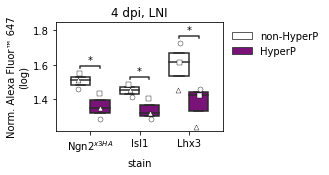

In [16]:
# Plotting params
x = 'stain'
y = 'Alexa Fluor™ 647-A'
hue = 'CTV_cat'

# Restrict to just NIL
DDRR_cat = False
cond = 'LNIx3HA'
order = ['HA (Ngn2$^{x3HA}$)', 'Isl1', 'Lhx3']
hue_order = ['non-CTV-low', 'CTV-low']


colormap = {'CTV-low': '#8b0288',
            'non-CTV-low': 'white'}
marker_list = ['o', 's', '^', 'D', 'P', 'X']

fig, ax = plt.subplots(1, 1, figsize=(3, 2))

# Restrict to just + DDRR
df_gmean_reps = data_4dpi_stain_mean.loc[(data_4dpi_stain_mean.DDRR_cat == DDRR_cat) & (data_4dpi_stain_mean.cond == cond)]
# df_gmean_reps.loc[:,'Norm Alexa Fluor™ 647-A (gmean)'] = 10**df_gmean_reps['Norm log(Alexa Fluor™ 647-A (gmean))']

# Plot log10 transformed -> well geometric means
for (i, replicate) in enumerate(df_gmean_reps.replicate.unique()):
    sns.stripplot(
        ax=ax, data=df_gmean_reps[df_gmean_reps.replicate == replicate],
        x=x, y='Norm log({})'.format(y+' (gmean)'), hue=hue,
        order=order, hue_order=hue_order,
        dodge=True, marker=marker_list[i],
        palette={'CTV-low': 'white', 'non-CTV-low': 'white'}, size=5,
        edgecolor='black', linewidth=0.4,)
    

# Plot as box
sns.boxplot(ax=ax,
    data=df_gmean_reps, 
    x=x, y='Norm log({})'.format(y+' (gmean)'), hue=hue,
    order=order, hue_order=hue_order, 
    palette={'CTV-low': '#8b0288', 'non-CTV-low': 'white'},
    width=0.8, whis=0, showfliers=False)
    
# Adjust labels
lmap = {'CTV-low':'HyperP', 'non-CTV-low':'non-HyperP'}
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=[lmap[i] for i in l[-len(hue_order):]],
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
ax.set_xticklabels(['Ngn2$^{x3HA}$', 'Isl1', 'Lhx3'])
ax.set_ylabel('Norm. Alexa Fluor™ 647\n(log)')
plt.title('4 dpi, LNI')

# Pairs for stats comp
pairs = [((stain, 'non-CTV-low'), (stain, 'CTV-low')) for stain in order]
annot = Annotator(ax=ax, data=df_gmean_reps, x=x, y='Norm log({})'.format(y+' (gmean)'), pairs=pairs, order=order, hue=hue, hue_order=hue_order)
annot.configure(test=ttest_ind_greater, text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

# plt.savefig(figpath + 'SI/4dpi_boxplot_Norm-hyperPvnon-{}.svg'.format(cond), bbox_inches='tight')


### Look at overall TF changes between +/- DDRR

/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


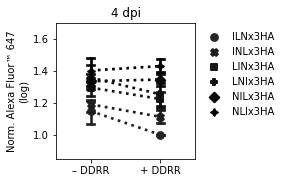

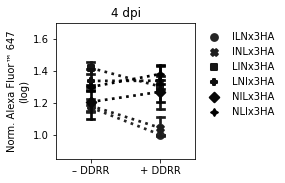

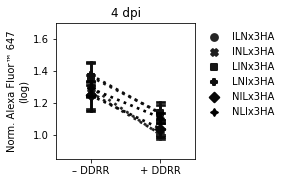

In [17]:
# Plotting params
x = 'DDRR_cat'
y = 'Alexa Fluor™ 647-A'
hue = 'cond'

order = [False, True]
hue_order = ['ILNx3HA', 'INLx3HA', 'LINx3HA', 'LNIx3HA', 'NILx3HA', 'NLIx3HA',]

marker_list = ['o', 'X', 's', 'P', 'D', (4, 1, 90), '$U+2726$']

palette = {'HA (Ngn2$^{x3HA}$)': '#068B89', 'Isl1': '#ED8163', 'Lhx3': '#498BC7'}
stain_list = ['HA (Ngn2$^{x3HA}$)', 'Isl1', 'Lhx3']

# Plot well geometric means for +DDRR
for (i, stain) in enumerate(stain_list):
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))

    sns.pointplot(ax=ax,
        data=data_4dpi_stain_mean_hyperP.loc[(data_4dpi_stain_mean_hyperP.stain == stain_list[i])], 
        x=x, y='Norm log({})'.format(y+' (gmean)'),
        errorbar='se', capsize=.1,
        hue=hue, order=order, hue_order=hue_order, linewidth=0.3, color='black',
        markers=marker_list, height=4, linestyles=':')


    # Move legend
    h,l = ax.get_legend_handles_labels()
    sns.move_legend(ax, handles=h[len(hue_order):], labels=l[len(hue_order):],
        title='', bbox_to_anchor=(1,1), loc='upper left', frameon=False)


    ax.set_ylim((0.85, 1.7))
    ax.set_xticklabels(['– DDRR', '+ DDRR'])
    ax.set_xlabel('')
    ax.set_ylabel('Norm. Alexa Fluor™ 647\n(log)')

    plt.title('4 dpi')
    # plt.savefig(figpath + 'SI/4dpi_ptplot-hyperP-DDRRvnon_{}-norm.svg'.format(stain_list[i], bbox_inches='tight'))

# Look at 14 dpi data

## Load 14 dpi data

In [18]:
# Directories
base_datadir = rd.datadir/'2022.11.07_HG_NILx3HA_reorder_14dpi_1-3'

# List of data folder names
dir_list = ['2022.11.07_HG_NILx3HA_reorder_14dpi_01', '2022.11.07_HG_NILx3HA_reorder_14dpi_02', '2022.11.09_HG_NILx3HA_reorder_14dpi_03']

# Store all data in list of dfs which will be converted to df at end
data = list()

# get all csvs for each dir
for (j, dir_name) in enumerate(dir_list):

    datadir = base_datadir/dir_name/'export_singlets'
    files = Path(datadir).glob('*.csv') 

    for i, file in enumerate(files):
        
        # Extract metadata from csv title
        match = re.search(
            'export_(?P<cond>.+)_(?P<sampleNum>\d)_(?P<subsetName>.+).csv', file.name)
        # If csv is a ctrl file it won't match so ignore
        if match is None:
            continue

        cond = match.group('cond')
        sampleNum = match.group('sampleNum')

        # Rename DDRR conditions
        DDRR_cat = False
        if cond[-4:] == 'DDRR':
           DDRR_cat = True
           cond = cond[:-5] # cut out .RIDD

        # Load as df and note header is on 0th row
        df = pd.read_csv(file, header=0)

        # Update columns in df with metadata from file name
        df['cond'] = cond
        df['replicate'] = j
        df['sampleNum'] = int(sampleNum)
        df['DDRR_cat'] = DDRR_cat

        data.append(df)

# Convert list of dfs into single df
data_14dpi = pd.concat(data, ignore_index=True)

# Eliminate any negative fluor
data_14dpi = data_14dpi.loc[
    (data_14dpi['eGFP-A'] > 0) &
    (data_14dpi['FSC-A'] > 0) &
    (data_14dpi['SSC-A'] > 0)
]

## Look at eGFP for NILDDRR to determine eGFP gate

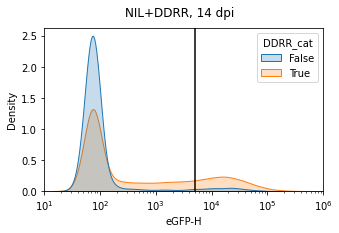

In [19]:
# Threshold for iMNs
eGFP_H_thresh = 5*10**3

# Downsample to 100,000 cells from NIL
small_data = data_14dpi[(data_14dpi['cond'] == 'NILx3HA')].sample(n=10**5, random_state=1)
# small_data = data[(data['cond'] == 'NIL') & (
#     data['HIP_cat'] == True)].sample(n=10**5, random_state=1)

# Plot eGFP-H
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
x = 'eGFP-H'
sns.kdeplot(data=small_data, x=x, hue='DDRR_cat',
            ax=ax, log_scale=(True, False), fill=True, common_norm=False)

# Title
plt.suptitle('NIL+DDRR, 14 dpi')
# Adjust limits
eGFP_lim = (10, 10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(eGFP_lim)
    sub_ax.axvline(eGFP_H_thresh, 0, 1, color='black')

# Misc plotting stuff
# fig.tight_layout()  # Helps improve white spacing
# plt.savefig(figpath + 'eGFP_H_dist.svg')

In [20]:
# Categorize iMNs based on eGFP_thresh
data_14dpi['eGFP_cat'] = 'fib'
data_14dpi.loc[(data_14dpi['eGFP-H'] > eGFP_H_thresh), 'eGFP_cat'] = 'iMN'

# Get total counts and percent of GFP-H+
well_group = ['cond', 'DDRR_cat', 'replicate']
count_df_reps = data_14dpi.groupby([*well_group,  'sampleNum', 'eGFP_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if no GFP-H+ rather than dropping row
percent_df_reps = (count_df_reps*100/count_df_reps.groupby([*well_group, 'sampleNum']).transform('sum')).reset_index(name='percent')

# Get iMN yield per condition
seedNum = 10**4 # Seeded 10k MEFs/96-well
data_iMN_yield_reps = (count_df_reps*100/seedNum).reset_index(name='yield')

# Extract just the iMNs
data_iMN_yield_reps = data_iMN_yield_reps.loc[(data_iMN_yield_reps['eGFP_cat'] == 'iMN')]
data_iMN_percent_reps = percent_df_reps.loc[(percent_df_reps['eGFP_cat'] == 'iMN')]

# Collapse to bio reps
data_iMN_yield = data_iMN_yield_reps.groupby(well_group).mean().reset_index()
data_iMN_percent = data_iMN_percent_reps.groupby(well_group).mean().reset_index()

## First compare NIL with and without NLI tag

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL_False vs. NILx3HA_False: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:1.749e-01 Stat=-1.647e+00
NIL_True vs. NILx3HA_True: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:2.518e-02 Stat=-3.488e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL_False vs. NILx3HA_False: t-test for independent samples from scipy with less 1-way (mean o

/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


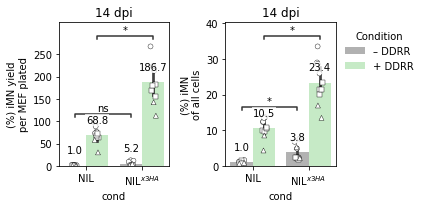

In [21]:
#  General plotting params
x = 'cond'
hue = 'DDRR_cat'
hue_order = [False, True]
units = 'sampleNum'
colormap = {hue_order[0]: 'black', hue_order[1]: 'limegreen'}
cond_list = ['NIL', 'NILx3HA']
marker_list = ['o', 's', '^', 'D']

# Pairs for stats comp
pairs = [(('NIL', False), ('NILx3HA', False)),
         (('NIL', True), ('NILx3HA', True))]

fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# Plot iMN yield per MEF plated
y = 'yield'
sns.barplot(ax=ax[0], data=data_iMN_yield_reps,
            x=x, y=y, hue=hue, hue_order=hue_order, order=cond_list,
            units=units,
            palette=colormap, alpha=0.3)
for (i, rep) in enumerate(data_iMN_yield_reps.replicate.unique()):
    sns.stripplot(
        ax=ax[0], data=data_iMN_yield_reps[data_iMN_yield_reps.replicate == rep],
        x=x, y=y, hue=hue, hue_order=hue_order, order=cond_list,
        dodge=True, marker=marker_list[i],
        palette={True: 'white', False: 'white'}, size=5,
        edgecolor='black', linewidth=0.4,)

# Add in stats for iMN yield
annot = Annotator(ax=ax[0], data=data_iMN_yield, x=x, y=y, pairs=pairs, order=cond_list, hue=hue, hue_order=hue_order)
annot.configure(test=ttest_ind_less, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()


# Plot iMN percent of all cells
y = 'percent'
sns.barplot(ax=ax[1], data=data_iMN_percent_reps,
            x=x, y=y, hue=hue, hue_order=hue_order, order=cond_list,
            units=units,
            palette=colormap, alpha=0.3)
for (i, rep) in enumerate(data_iMN_percent_reps.replicate.unique()):
    sns.stripplot(
        ax=ax[1], data=data_iMN_percent_reps[data_iMN_percent_reps.replicate == rep],
        x=x, y=y, hue=hue, hue_order=hue_order, order=cond_list,
        dodge=True, marker=marker_list[i],
        palette={True: 'white', False: 'white'}, size=5,
        edgecolor='black', linewidth=0.4,)

# Add in stats for iMN percent
annot = Annotator(ax=ax[1], data=data_iMN_percent, x=x, y=y, pairs=pairs, order=cond_list, hue=hue, hue_order=hue_order)
annot.configure(test=ttest_ind_less, text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()
    

# Format
# fig.suptitle('14 dpi')
ax[0].set_title('14 dpi')
ax[1].set_title('14 dpi')
ax[0].yaxis.set_label_text('(%) iMN yield\nper MEF plated')
ax[0].set_yticks(np.arange(0, 300, 50))
ax[1].yaxis.set_label_text('(%) iMN\nof all cells')
# ax[1].set_yticks(np.arange(0, 30, 5))

# Adjust labels
lmap = {'True':'+ DDRR', 'False':'\u2013 DDRR'}
ax[0].get_legend().remove()
h,l = ax[1].get_legend_handles_labels()
sns.move_legend(ax[1], handles=h[-len(hue_order):],labels=[lmap[i] for i in l[-len(hue_order):]],
    title='Condition', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Add barplot labels
for sub_ax in plt.gcf().get_axes():
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.1f', padding=10)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))

    sub_ax.set_xticklabels(['NIL', 'NIL$^{x3HA}$'])


fig.tight_layout()
# plt.savefig(figpath + 'iMN_yield-percent_NIL-v-x3HA.svg', bbox_inches='tight')


## Yield

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NILx3HA vs. NLIx3HA: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:5.676e-02 Stat=2.036e+00
NILx3HA vs. LNIx3HA: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:1.412e-02 Stat=2.717e+00


/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


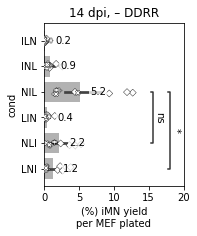

In [22]:
# General plotting params
y = 'cond'
x = 'yield'
cond_list = ['ILNx3HA', 'INLx3HA', 'NILx3HA', 'LINx3HA', 'NLIx3HA', 'LNIx3HA']
color = 'black'
units = 'sampleNum'
marker_list = ['o', 's', '^', 'D', 'P', 'X']

fig, ax = plt.subplots(1, 1, figsize=(2.5, 3))

# Plot iMN percent of all cells
sns.barplot(ax=ax, data=data_iMN_yield_reps.loc[(data_iMN_yield_reps['DDRR_cat'] == False)],
            x=x, y=y, order=cond_list, units=units,
            color=color, alpha=0.3, orient='h')

for (i, rep) in enumerate(rep_list):
    sns.stripplot(
        ax=ax,
        data=data_iMN_yield_reps.loc[(data_iMN_yield_reps['DDRR_cat'] == False) & (data_iMN_yield_reps.replicate == rep)],
        x=x, y=y, order=cond_list,
        marker=marker_list[i],
        color='white', size=5, orient='h', dodge=True,
        edgecolor='black', linewidth=0.4
        )


# Add in stats
pairs = [
    ('NILx3HA', 'NLIx3HA'),
    ('NILx3HA', 'LNIx3HA')]
annot = Annotator(ax=ax,
    data=data_iMN_yield_reps.loc[data_iMN_yield_reps['DDRR_cat'] == False],
    x=x, y=y, pairs=pairs, 
    order=cond_list, orient='h')
annot.configure(test=ttest_ind_greater, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.2)

# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.1f', padding=10)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))

ax.set_yticklabels(
    ['ILN', 'INL', 'NIL', 'LIN', 'NLI', 'LNI'])

# Format
# fig.tight_layout()  # Helps improve white spacing
plt.title('14 dpi, \u2013 DDRR')
ax.xaxis.set_label_text('(%) iMN yield\nper MEF plated')
ax.set_xticks(np.arange(0, 25, 5))

# plt.savefig(figpath + 'iMN_yield_noDDRR_hor_sort.svg', bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NLIx3HA vs. LNIx3HA: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:3.678e-04 Stat=-4.060e+00


/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position fou

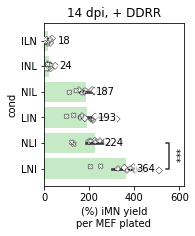

In [23]:
# General plotting params
y = 'cond'
x = 'yield'
cond_list = ['ILNx3HA', 'INLx3HA', 'NILx3HA', 'LINx3HA', 'NLIx3HA', 'LNIx3HA']
color = 'limegreen'
units = 'sampleNum'
marker_list = ['o', 's', '^', 'D', 'P', 'X']

fig, ax = plt.subplots(1, 1, figsize=(2.5, 3))
# Plot iMN percent of all cells
sns.barplot(ax=ax, data=data_iMN_yield_reps.loc[(data_iMN_yield_reps['DDRR_cat'] == True)],
            x=x, y=y, order=cond_list, units=units,
            color=color, alpha=0.3, orient='h')
for (i, rep) in enumerate(rep_list):
    sns.stripplot(
        ax=ax,
        data=data_iMN_yield_reps.loc[(data_iMN_yield_reps['DDRR_cat'] == True) & (data_iMN_yield_reps.replicate == rep)],
        x=x, y=y, order=cond_list,
        marker=marker_list[i],
        color='white', size=5, orient='h', dodge=True,
        edgecolor='black', linewidth=0.4
        )

# Add in stats
pairs = [
    ('LNIx3HA', 'NLIx3HA')]
annot = Annotator(ax=ax,
    data=data_iMN_yield_reps.loc[data_iMN_yield_reps['DDRR_cat'] == True],
    x=x, y=y, pairs=pairs, 
    order=cond_list, orient='h')
annot.configure(test=ttest_ind_less, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate()

# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=10)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))

ax.set_yticklabels(
    ['ILN', 'INL', 'NIL', 'LIN', 'NLI', 'LNI'])

# Format
# fig.tight_layout()  # Helps improve white spacing
plt.title('14 dpi, + DDRR')
ax.xaxis.set_label_text('(%) iMN yield\nper MEF plated')
ax.set_xticks(np.arange(0, 700, 200))

# plt.savefig(figpath + 'iMN_yield_DDRR_hor_sort.svg', bbox_inches='tight')

### Plot percent

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NILx3HA vs. NLIx3HA: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:1.288e-01 Stat=1.910e+00
NILx3HA vs. LNIx3HA: t-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:4.604e-02 Stat=2.858e+00


/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Text(0.5, 6.0, '(%) iMN\nof all cells')

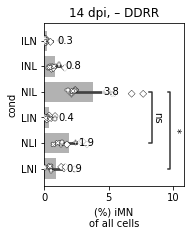

In [24]:
# General plotting params
y = 'cond'
x = 'percent'
cond_list = ['ILNx3HA', 'INLx3HA', 'NILx3HA', 'LINx3HA', 'NLIx3HA', 'LNIx3HA']
color = 'black'
units = 'sampleNum'
marker_list = ['o', 's', '^', 'D', 'P', 'X']

fig, ax = plt.subplots(1, 1, figsize=(2.5, 3))

# Plot iMN percent of all cells
sns.barplot(ax=ax, data=data_iMN_percent_reps.loc[(data_iMN_percent_reps['DDRR_cat'] == False)],
            x=x, y=y, order=cond_list, units=units,
            color=color, alpha=0.3, orient='h')
for (i, rep) in enumerate(rep_list):
    sns.stripplot(
        ax=ax,
        data=data_iMN_percent_reps.loc[(data_iMN_percent_reps['DDRR_cat'] == False) & (data_iMN_percent_reps.replicate == rep)],
        x=x, y=y, order=cond_list,
        marker=marker_list[i],
        color='white', size=5, orient='h', dodge=True,
        edgecolor='black', linewidth=0.4
        )

# Add in stats
pairs = [
    ('NILx3HA', 'NLIx3HA'),
    ('NILx3HA', 'LNIx3HA')]
annot = Annotator(ax=ax,
    data=data_iMN_percent.loc[data_iMN_percent['DDRR_cat'] == False],
    x=x, y=y, pairs=pairs, 
    order=cond_list, orient='h')
annot.configure(test=ttest_ind_greater, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate()

# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.1f', padding=10)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))

ax.set_yticklabels(
    ['ILN', 'INL', 'NIL', 'LIN', 'NLI', 'LNI'])

# Format
# fig.tight_layout()  # Helps improve white spacing
plt.title('14 dpi, \u2013 DDRR')
ax.xaxis.set_label_text('(%) iMN\nof all cells')
# ax.set_xticks(np.arange(0, 5, 1))

# plt.savefig(figpath + 'SI/iMN_percent_noDDRR_hor_sort.svg', bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NLIx3HA vs. LNIx3HA: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:6.091e-02 Stat=-1.958e+00


/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Text(0.5, 6.0, '(%) iMN\nof all cells')

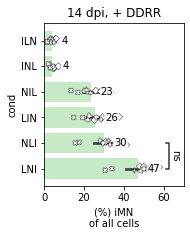

In [25]:
# General plotting params
y = 'cond'
x = 'percent'
units = 'sampleNum'
cond_list = ['ILNx3HA', 'INLx3HA', 'NILx3HA', 'LINx3HA', 'NLIx3HA', 'LNIx3HA']
color = 'limegreen'

marker_list = ['o', 's', '^', 'D', 'P', 'X']

fig, ax = plt.subplots(1, 1, figsize=(2.5, 3))

# Plot iMN percent of all cells
sns.barplot(ax=ax, data=data_iMN_percent_reps.loc[(data_iMN_percent_reps['DDRR_cat'] == True)],
            x=x, y=y, order=cond_list, units=units,
            color=color, alpha=0.3, orient='h')
for (i, rep) in enumerate(rep_list):
    sns.stripplot(
        ax=ax,
        data=data_iMN_percent_reps.loc[(data_iMN_percent_reps['DDRR_cat'] == True) & (data_iMN_percent_reps.replicate == rep)],
        x=x, y=y, order=cond_list,
        marker=marker_list[i],
        color='white', size=5, orient='h', dodge=True,
        edgecolor='black', linewidth=0.4
        )

# Add in stats
pairs = [
    ('LNIx3HA', 'NLIx3HA')]
annot = Annotator(ax=ax,
    data=data_iMN_percent.loc[data_iMN_percent['DDRR_cat'] == True],
    x=x, y=y, pairs=pairs, 
    order=cond_list, orient='h')
annot.configure(test=ttest_ind_less, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate()

# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=10)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))


# ax.set_yticklabels(
#     ['ILN$^{x3HA}$', 'IN$^{x3HA}$L', 'N$^{x3HA}$IL', 'LIN$^{x3HA}$', 'N$^{x3HA}$LI', 'LIN$^{x3HA}$', 'NIL'])

ax.set_yticklabels(
    ['ILN', 'INL', 'NIL', 'LIN', 'NLI', 'LNI'])

# Format
# fig.tight_layout()  # Helps improve white spacing
plt.title('14 dpi, + DDRR')
ax.xaxis.set_label_text('(%) iMN\nof all cells')
# ax.set_xticks(np.arange(0, 25, 5))
# ax.set_xlim((0, 22))

# plt.savefig(figpath + 'SI/iMN_percent_DDRR_hor_sort_minLabel.svg', bbox_inches='tight')

# Plot hyperP 4 dpi protein data against 14 dpi data

Combine 4 dpi well means with 14 dpi and line up replicate data

Normalize

In [26]:
x = 'Alexa Fluor™ 647-A'
stain_list = ['HA (Ngn2$^{x3HA}$)', 'Isl1', 'Lhx3']

# Calculate mean of each sample
well_group = ['stainrep', 'stain', 'cond', 'DDRR_cat', 'replicate']
data_4dpi_stain_mean_bulk = data_4dpi.groupby(
        well_group)[x].apply(scipy.stats.gmean).reset_index(name=x+' (gmean)')

# For violin plots, first log10 transform data
data_4dpi['log({})'.format(x)] = np.log10(data_4dpi[x])
data_4dpi_stain_mean_bulk['log({})'.format(x+' (gmean)')] = np.log10(data_4dpi_stain_mean_bulk[x+' (gmean)'])

# Normalize to ILN + DDRR in log10 space for each rep
rep_list = data_4dpi_stain_mean['replicate'].unique()
base = np.zeros((len(rep_list), len(stain_list)))

for (i, replicate) in enumerate(rep_list):
    for (j, stain) in enumerate(stain_list):
        base[i, j] = data_4dpi_stain_mean_bulk.loc[
            (data_4dpi_stain_mean_bulk.stain == stain) & 
            (data_4dpi_stain_mean_bulk.cond == 'ILNx3HA') &
            (data_4dpi_stain_mean_bulk.DDRR_cat == True) &
            (data_4dpi_stain_mean_bulk.replicate == replicate)]['log({})'.format(x+' (gmean)')].mean()

        data_4dpi.loc[(data_4dpi.replicate==replicate) & (data_4dpi.stain==stain), 'Norm log({})'.format(x)] = \
            data_4dpi[(data_4dpi.replicate==replicate) & (data_4dpi.stain==stain)]['log({})'.format(x)] - base[i,j] + 1

        data_4dpi_stain_mean_bulk.loc[(data_4dpi_stain_mean_bulk.replicate==replicate) & (data_4dpi_stain_mean_bulk.stain==stain), 'Norm log({})'.format(x+' (gmean)')] = \
            data_4dpi_stain_mean_bulk[(data_4dpi_stain_mean_bulk.replicate==replicate) & (data_4dpi_stain_mean_bulk.stain==stain)]['log({})'.format(x+' (gmean)')] - base[i,j] + 1

Combine data

In [27]:
x = 'Norm log(Alexa Fluor™ 647-A (gmean))'

# Calculate geo mean of each sample
well_group = ['cond', 'DDRR_cat']

# Calculate mean and SEM for stain in hyperP
# Restrict to just NBW in raw because BAL staining was higher but didn't have non-DDRR
data_4dpi_stain_mean_NBW_bulk = data_4dpi_stain_mean_bulk[ data_4dpi_stain_mean_bulk['stainrep'] == 1 ]
data_both_mean = data_4dpi_stain_mean_NBW_bulk.groupby(['stain', *well_group])[x].mean().reset_index()
data_both_SEM = data_4dpi_stain_mean_NBW_bulk.groupby(['stain', *well_group])[x].sem().reset_index()
data_both_mean = data_both_mean[data_both_mean.cond != 'Ctrl-puro']
data_both_SEM = data_both_SEM[data_both_SEM.cond != 'Ctrl-puro']

# Calculate mean and SEM for reprogramming
data_iMNpercent_rep_mean = data_iMN_percent_reps.groupby([*well_group, 'replicate'])['percent'].mean().reset_index(name='iMN percent') # Avg out tech reps first
data_iMN_percent_mean = data_iMNpercent_rep_mean.groupby(well_group)['iMN percent'].mean().reset_index()
data_iMN_percent_SEM = data_iMNpercent_rep_mean.groupby(well_group)['iMN percent'].sem().reset_index()
data_iMN_yield_rep_mean = data_iMN_yield_reps.groupby([*well_group, 'replicate'])['yield'].mean().reset_index(name='iMN yield') # Avg out tech reps first
data_iMN_yield_mean = data_iMN_yield_rep_mean.groupby(well_group)['iMN yield'].mean().reset_index()
data_iMN_yield_SEM = data_iMN_yield_rep_mean.groupby(well_group)['iMN yield'].sem().reset_index()

# Combine iMN and mean staining data
for index, row in data_both_mean.iterrows(): 
    if row.cond not in data_iMN_percent_mean.cond.unique():
        continue
    data_both_mean.loc[index, 'iMN percent'] = float(data_iMN_percent_mean[(data_iMN_percent_mean.cond==row.cond) & (data_iMN_percent_mean.DDRR_cat==row.DDRR_cat)]['iMN percent'])
    data_both_mean.loc[index, 'iMN yield'] = float(data_iMN_yield_mean[(data_iMN_yield_mean.cond==row.cond) & (data_iMN_yield_mean.DDRR_cat==row.DDRR_cat)]['iMN yield'])
for index, row in data_both_SEM.iterrows(): 
    if row.cond not in data_iMN_percent_mean.cond.unique():
        continue
    data_both_SEM.loc[index, 'iMN percent'] = float(data_iMN_percent_SEM[(data_iMN_percent_SEM.cond==row.cond) & (data_iMN_percent_SEM.DDRR_cat==row.DDRR_cat)]['iMN percent'])
    data_both_SEM.loc[index, 'iMN yield'] = float(data_iMN_yield_SEM[(data_iMN_yield_SEM.cond==row.cond) & (data_iMN_yield_SEM.DDRR_cat==row.DDRR_cat)]['iMN yield'])

### Yield

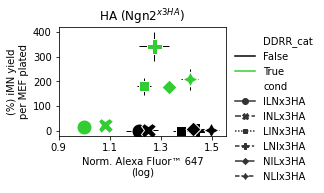

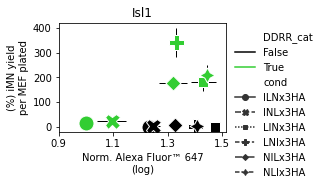

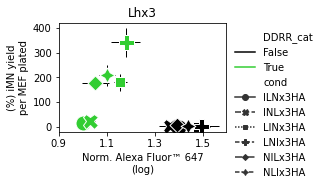

In [28]:
# Plotting params
x = 'Norm log(Alexa Fluor™ 647-A (gmean))'
y = 'iMN yield'
hue = 'DDRR_cat'
hue_order = [False, True]
cond_list = ['ILNx3HA', 'INLx3HA', 'NILx3HA', 'LINx3HA', 'NLIx3HA', 'LNIx3HA']
colormap = {True: 'limegreen',
            False: 'black'}

# Plot
for (i, stain) in enumerate(stain_list):
    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    f = sns.lineplot(ax=ax,
        data=data_both_mean.loc[(data_both_mean.stain == stain)], 
        x=x, y=y,
        hue=hue, style='cond',
        markers=True, markersize=15, markeredgecolor='white', markeredgewidth=1,
        palette=colormap)

    # Plots error
    ax.errorbar(x=data_both_mean.loc[(data_both_mean.stain == stain)][x],
                y=data_both_mean.loc[(data_both_mean.stain == stain)][y],
                xerr=data_both_SEM.loc[(data_both_SEM.stain == stain)][x],
                yerr=data_both_SEM.loc[(data_both_SEM.stain == stain)][y],
                color='None', ecolor='black', elinewidth=1, zorder=-100)
                

    sns.move_legend(ax, title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    ax.set_xlabel('Norm. Alexa Fluor™ 647\n(log)')
    ax.yaxis.set_label_text('(%) iMN yield\nper MEF plated')
    plt.title(stain)

    # Adjust labels
    for sub_ax in plt.gcf().get_axes():
        sub_ax.set_xticks(np.arange(0.9, 1.7, 0.2))
    # fig.tight_layout()  # Helps improve white spacing
    plt.savefig(figpath + 'iMN_yield_v_BULKexpression_no_reps_{}-Norm.svg'.format(stain), bbox_inches='tight')

Plot hyperP vs. non in +DDRR

/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


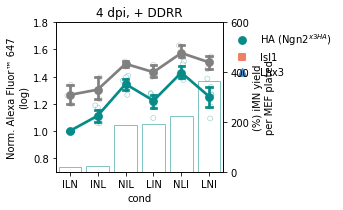

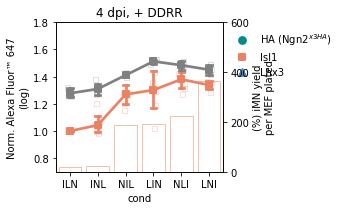

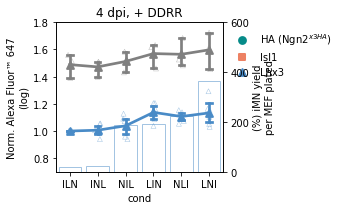

In [29]:
# Plotting params
x = 'cond'
y = 'Alexa Fluor™ 647-A'
hue = 'stain'

cond_list = ['ILNx3HA', 'INLx3HA', 'NILx3HA', 'LINx3HA', 'NLIx3HA', 'LNIx3HA']
marker_list = ['o', 's', '^', 'D', 'P', 'X']
hue_order = ['HA (Ngn2$^{x3HA}$)', 'Isl1', 'Lhx3']
palette = {'HA (Ngn2$^{x3HA}$)': '#068B89', 'Isl1': '#ED8163', 'Lhx3': '#498BC7'}
markers ={'HA (Ngn2$^{x3HA}$)': 'o', 'Isl1': 's', 'Lhx3': '^'}
units = 'sampleNum'

# Plot stain with hyperP
for (i, stain) in enumerate(hue_order):
    DDRR_cat = True

    fig, ax = plt.subplots(1, 1, figsize=(3, 2.75))

    # Plot well geometric means for + DDRR, hyperP
    CTV_cat = 'CTV-low'
    sns.pointplot(ax=ax,
        data=data_4dpi_stain_mean.loc[(data_4dpi_stain_mean.stain == stain) & (data_4dpi_stain_mean.DDRR_cat == DDRR_cat) & (data_4dpi_stain_mean.CTV_cat == CTV_cat)], 
        x=x, y='Norm log({})'.format(y+' (gmean)'),
        errorbar='se', capsize=.2,
        hue=hue, order=cond_list, hue_order=hue_order, linewidth=0.5,
        palette=palette, markers=marker_list, height=4)
    sns.stripplot(
        ax=ax,
        data=data_4dpi_stain_mean.loc[(data_4dpi_stain_mean.stain == stain) & (data_4dpi_stain_mean.DDRR_cat == DDRR_cat) & (data_4dpi_stain_mean.CTV_cat == CTV_cat)],
        x=x, y='Norm log({})'.format(y+' (gmean)'),
        order=cond_list,
        dodge=False, marker=markers[stain],
        color='white', size=5, 
        edgecolor=palette[stain], linewidth=0.5, alpha=0.5, zorder=-100)

    # Plot well geometric means for + DDRR, non-hyperP
    CTV_cat = 'non-CTV-low'
    DDRR_cat = False
    sns.pointplot(ax=ax,
        data=data_4dpi_stain_mean.loc[(data_4dpi_stain_mean.stain == stain) & (data_4dpi_stain_mean.DDRR_cat == DDRR_cat) & (data_4dpi_stain_mean.CTV_cat == CTV_cat)], 
        x=x, y='Norm log({})'.format(y+' (gmean)'),
        errorbar='se', capsize=.2,
        hue=hue, order=cond_list, hue_order=hue_order, linewidth=0.5,
        palette={'HA (Ngn2$^{x3HA}$)': 'grey', 'Isl1': 'grey', 'Lhx3': 'grey'}, markers=marker_list, height=4)
    sns.stripplot(
        ax=ax,
        data=data_4dpi_stain_mean.loc[(data_4dpi_stain_mean.stain == stain) & (data_4dpi_stain_mean.DDRR_cat == DDRR_cat) & (data_4dpi_stain_mean.CTV_cat == CTV_cat)],
        x=x, y='Norm log({})'.format(y+' (gmean)'),
        order=cond_list,
        dodge=False, marker=markers[stain],
        color='white', size=5, 
        edgecolor='grey', linewidth=0.5, alpha=0.5, zorder=-90)

    ax_bar = ax.twinx()
    sns.barplot(ax=ax_bar, data=data_iMN_yield_reps.loc[(data_iMN_yield_reps['DDRR_cat'] == True)],
                x='cond', y='yield', order=cond_list, ci=None,
                edgecolor=palette[stain], alpha=0.5, fill=False)
    ax_bar.set_yticks(np.arange(0, 700, 200))
    ax_bar.set_ylabel('(%) iMN yield\nper MEF plated')


    # Move legend
    h,l = ax.get_legend_handles_labels()
    sns.move_legend(ax, handles=h[:-len(hue_order)], labels=l[:-len(hue_order)],
        title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)


    # Adjust labels
    ax.set_yticks(np.arange(0.8, 1.9, 0.2))
    ax.set_ylim((0.7, 1.8)) # Trim y axis
    ax.set_xticklabels(['ILN', 'INL', 'NIL', 'LIN', 'NLI', 'LNI'])
    ax.set_ylabel('Norm. Alexa Fluor™ 647\n(log)')

    plt.title('4 dpi, + DDRR')
    # fig.tight_layout()  # Helps improve white spacing
    # plt.savefig(figpath + 'SI/4dpi_ptplot_Norm-DDRR-hyperPvnon-{}-withYield.svg'.format(stain), bbox_inches='tight')